In [1]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

#### 1. Давайте проанализируем данные опроса 4361 женщин из Ботсваны:

О каждой из них мы знаем:

- сколько детей она родила (признак ceb)
- возраст (age)
- длительность получения образования (educ)
- религиозная принадлежность (religion)
- идеальное, по её мнению, количество детей в семье (idlnchld)
- была ли она когда-нибудь замужем (evermarr)
- возраст первого замужества (agefm)
- длительность получения образования мужем (heduc)
- знает ли она о методах контрацепции (knowmeth)
- использует ли она методы контрацепции (usemeth)
- живёт ли она в городе (urban)
- есть ли у неё электричество, радио, телевизор и велосипед (electric, radio, tv, bicycle)

Давайте научимся оценивать количество детей ceb по остальным признакам.

Загрузите данные и внимательно изучите их. Сколько разных значений принимает признак $religion$?

In [2]:
botswana = pd.read_csv('botswana.tsv', sep='\t')
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0


In [3]:
botswana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ceb       4361 non-null   int64  
 1   age       4361 non-null   int64  
 2   educ      4361 non-null   int64  
 3   religion  4361 non-null   object 
 4   idlnchld  4241 non-null   float64
 5   knowmeth  4354 non-null   float64
 6   usemeth   4290 non-null   float64
 7   evermarr  4361 non-null   int64  
 8   agefm     2079 non-null   float64
 9   heduc     1956 non-null   float64
 10  urban     4361 non-null   int64  
 11  electric  4358 non-null   float64
 12  radio     4359 non-null   float64
 13  tv        4359 non-null   float64
 14  bicycle   4358 non-null   float64
dtypes: float64(9), int64(5), object(1)
memory usage: 511.2+ KB


In [4]:
botswana.religion.value_counts()

spirit        1841
other         1080
protestant     993
catholic       447
Name: religion, dtype: int64

#### 2. Во многих признаках есть пропущенные значения. Сколько объектов из 4361 останется, если выбросить все, содержащие пропуски? 

In [5]:
filtered = botswana.dropna()
filtered.shape

(1834, 15)

#### 3. В разных признаках пропуски возникают по разным причинам и должны обрабатываться по-разному.

Например, в признаке $agefm$ пропуски стоят только там, где $evermarr=0$, то есть, они соответствуют женщинам, никогда не выходившим замуж. Таким образом, для этого признака $NaN$ соответствует значению "не применимо".

В подобных случаях, когда признак $x_1$ на части объектов в принципе не может принимать никакие значения, рекомендуется поступать так:

- создать новый бинарный признак
$$x_2=\begin{equation*}
 \begin{cases}
   1, \text{$x_1 = не применимо,$}
   \\
   0, \text{$ иначе$};
   \\
 \end{cases}
\end{equation*}$$


- заменить "не применимо" в $x_1$ на произвольную константу $c$, которая среди других значений $x_1$ не встречается.

Теперь, когда мы построим регрессию на оба признака и получим модель вида $$y=\beta_0 + \beta_1 x_1 + \beta_2 x_2,$$
на тех объектах, где $x_1$ было измерено, регрессионное уравнение примет вид $$y=\beta_0 + \beta_1 x,$$ а там, где $x_1$ было "не применимо", получится $$y=\beta_0 + \beta_1 c + \beta_2.$$ Выбор $c$ влияет только на значение и интерпретацию $\beta_2$, но не $\beta_1$.

Давайте используем этот метод для обработки пропусков в agefm и heduc.

1. Создайте признак $nevermarr$, равный единице там, где в $agefm$ пропуски.
2. Удалите признак $evermarr$ — в сумме с $nevermarr$ он даёт константу, значит, в нашей матрице $X$ будет мультиколлинеарность.
3. Замените $NaN$ в признаке $agefm$ на $c_{agefm} = 0$.
4. У объектов, где $nevermarr$ = 1, замените $NaN$ в признаке $heduc$ на $c_{heduc} = −1$ (ноль использовать нельзя, так как он уже встречается у некоторых объектов выборки).

Сколько осталось пропущенных значений в признаке $heduc$?

In [6]:
botswana['nevermarr'] = botswana['agefm'].isnull() * 1
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,evermarr,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,1,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,1,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,1,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [7]:
del botswana['evermarr']
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,NaN,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [8]:
botswana.agefm.fillna(value=0, inplace=True)
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,NaN,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [9]:
botswana.heduc[botswana.heduc.isnull() & botswana.nevermarr.values == 1] = -1
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0


In [10]:
botswana.heduc.isnull().value_counts()

False    4238
True      123
Name: heduc, dtype: int64

123 пропущенных значения в признаке $heduc$ все еще осталось после обработки данных

#### 4. Избавимся от оставшихся пропусков.

Для признаков $idlnchld$, $heduc$ и $usemeth$ проведите операцию, аналогичную предыдущей: создайте индикаторы пропусков по этим признакам ($idlnchld\_noans$, $heduc\_noans$, $usemeth\_noans$), замените пропуски на нехарактерные значения ($c_{idlnchld} = −1$, $c_{heduc2}=−2$ (значение -1 мы уже использовали), $c_{usemeth}=−1$).

Остались только пропуски в признаках $knowmeth$, $electric$, $radio$, $tv$ и $bicycle$. Их очень мало, так что удалите объекты, на которых их значения пропущены.

Какого размера теперь наша матрица данных? Умножьте количество строк на количество всех столбцов (включая отклик $ceb$).

In [11]:
botswana['idlnchld_noans'] = botswana['idlnchld'].isnull() * 1
botswana['heduc_noans'] = botswana['heduc'].isnull() * 1
botswana['usemeth_noans'] = botswana['usemeth'].isnull() * 1

botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0


In [12]:
botswana.idlnchld[botswana.idlnchld.isnull()] = -1
botswana.heduc[botswana.heduc.isnull()] = -2
botswana.usemeth[botswana.usemeth.isnull()] = -1
botswana.head()

,ceb,age,educ,religion,idlnchld,knowmeth,usemeth,agefm,heduc,urban,electric,radio,tv,bicycle,nevermarr,idlnchld_noans,heduc_noans,usemeth_noans
0,0,18,10,catholic,4.0,1.0,1.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
1,2,43,11,protestant,2.0,1.0,1.0,20.0,14.0,1,1.0,1.0,1.0,1.0,0,0,0,0
2,0,49,4,spirit,4.0,1.0,0.0,22.0,1.0,1,1.0,1.0,0.0,0.0,0,0,0,0
3,0,24,12,other,2.0,1.0,0.0,0.0,-1.0,1,1.0,1.0,1.0,1.0,1,0,0,0
4,3,32,13,other,3.0,1.0,1.0,24.0,12.0,1,1.0,1.0,1.0,1.0,0,0,0,0


In [13]:
botswana[['usemeth', 'heduc', 'idlnchld']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4361 entries, 0 to 4360
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   usemeth   4361 non-null   float64
 1   heduc     4361 non-null   float64
 2   idlnchld  4361 non-null   float64
dtypes: float64(3)
memory usage: 102.3 KB


In [14]:
botswana.dropna(inplace=True) 
botswana.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4348 entries, 0 to 4360
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ceb             4348 non-null   int64  
 1   age             4348 non-null   int64  
 2   educ            4348 non-null   int64  
 3   religion        4348 non-null   object 
 4   idlnchld        4348 non-null   float64
 5   knowmeth        4348 non-null   float64
 6   usemeth         4348 non-null   float64
 7   agefm           4348 non-null   float64
 8   heduc           4348 non-null   float64
 9   urban           4348 non-null   int64  
 10  electric        4348 non-null   float64
 11  radio           4348 non-null   float64
 12  tv              4348 non-null   float64
 13  bicycle         4348 non-null   float64
 14  nevermarr       4348 non-null   int64  
 15  idlnchld_noans  4348 non-null   int64  
 16  heduc_noans     4348 non-null   int64  
 17  usemeth_noans   4348 non-null   i

In [15]:
matrix_size = botswana.shape[0] * botswana.shape[1]
print(f'Feature matrix size: {matrix_size} entries')

Feature matrix size: 78264 entries


#### 5.  Постройте регрессию количества детей ceb на все имеющиеся признаки методом <code>smf.ols</code>, как в разобранном до этого примере. Какой получился коэффициент детерминации $R^2$ ? Округлите до трёх знаков после десятичной точки.

In [16]:
m1 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc + urban \
             + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans',
             data=botswana)
fitted = m1.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     412.5
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:04:58   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

Посмотрим на распределение остатков:

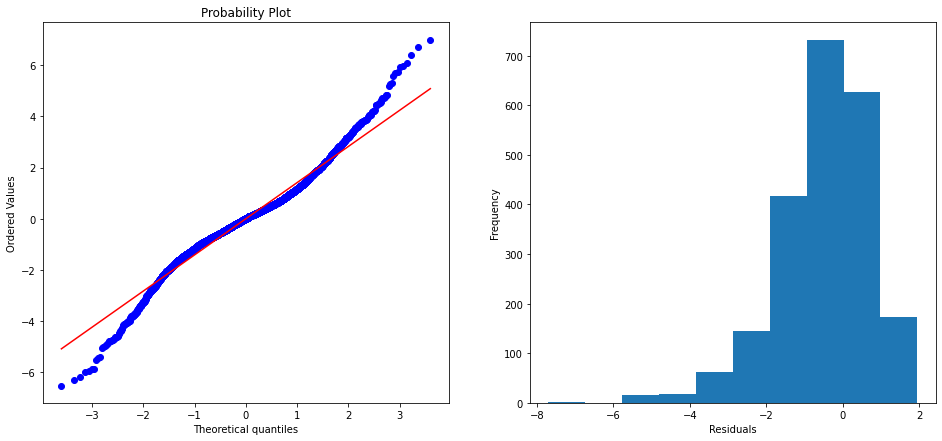

In [17]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.subplot(1,2,2)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals')
plt.show()

Логарифмическая модель не применима, так как целевой признак содержит значение 0 детей.

#### 6. Обратите внимание, что для признака <b>$religion$</b> в модели автоматически создалось несколько бинарных фиктивных переменных. Сколько их?

Всего 4 возможных значения религии. 3 признака была создана при помощи dummy переменных (1 избыточный)

#### 7. Проверьте критерием Бройша-Пагана гомоскедастичность ошибки в построенной модели. Выполняется ли она?

Если ошибка гетероскедастична, перенастройте модель, сделав поправку Уайта типа $HC1$. 

Используем критерий Бройша-Пагана для проверки гомоскедастичности ошибок:

In [18]:
print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

Breusch-Pagan test: p=0.000000


Ошибки гетероскедастичны (p-value < 0.05), значит, значимость признаков может определяться неверно. Сделаем поправку Уайта:

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     345.0
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:04:58   Log-Likelihood:                -7732.1
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4328   BIC:                         1.563e+04
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1

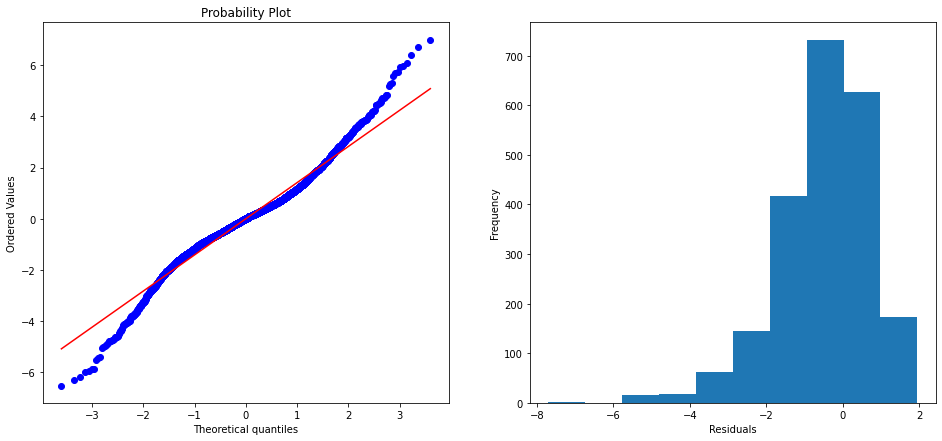

In [19]:
m2 = smf.ols('ceb ~ age + educ + religion + idlnchld + knowmeth + usemeth + agefm + heduc + urban \
             + electric + radio + tv + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans',
             data=botswana)

fitted_2 = m2.fit(cov_type='HC1')
print(fitted_2.summary())

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sc.stats.probplot(fitted_2.resid, dist='norm', plot=plt)
plt.subplot(1,2,2)
np.log(fitted_2.resid).plot.hist()
plt.xlabel('Residuals')
plt.show()

#### 8. Удалите из модели незначимые признаки $religion$, $radio$ и $tv$. Проверьте гомоскедастичность ошибки, при необходимости сделайте поправку Уайта.

Не произошло ли значимого ухудшения модели после удаления этой группы признаков? Проверьте с помощью критерия Фишера. Чему равен его достигаемый уровень значимости? Округлите до четырёх цифр после десятичной точки.

Если достигаемый уровень значимости получился маленький, верните все удалённые признаки; если он достаточно велик, оставьте модель без религии, тв и радио.

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     559.5
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:04:59   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.198     -5.

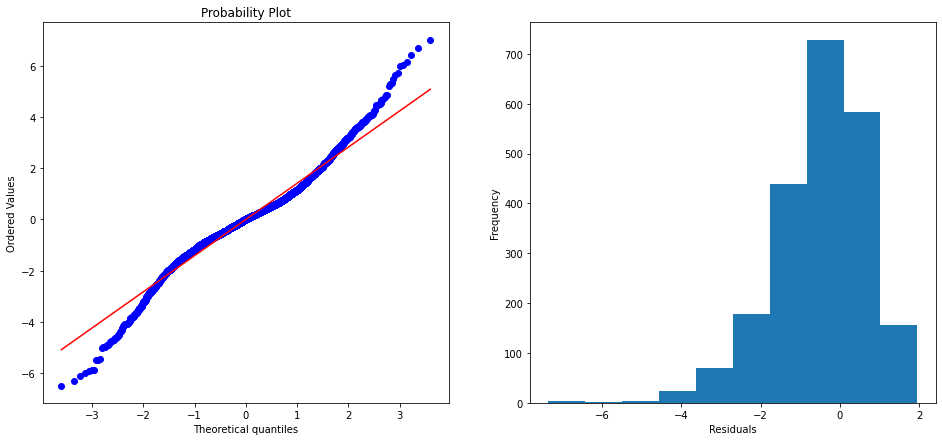

Breusch-Pagan test: p=0.000000


In [20]:
m3 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc + urban \
             + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans',
             data=botswana)

fitted_3 = m3.fit()
print(fitted_3.summary())

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sc.stats.probplot(fitted_3.resid, dist='norm', plot=plt)
plt.subplot(1,2,2)
np.log(fitted_3.resid).plot.hist()
plt.xlabel('Residuals')
plt.show()

print('Breusch-Pagan test: p=%f' % sms.het_breuschpagan(fitted_3.resid, fitted_3.model.exog)[1])

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:05:00   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.

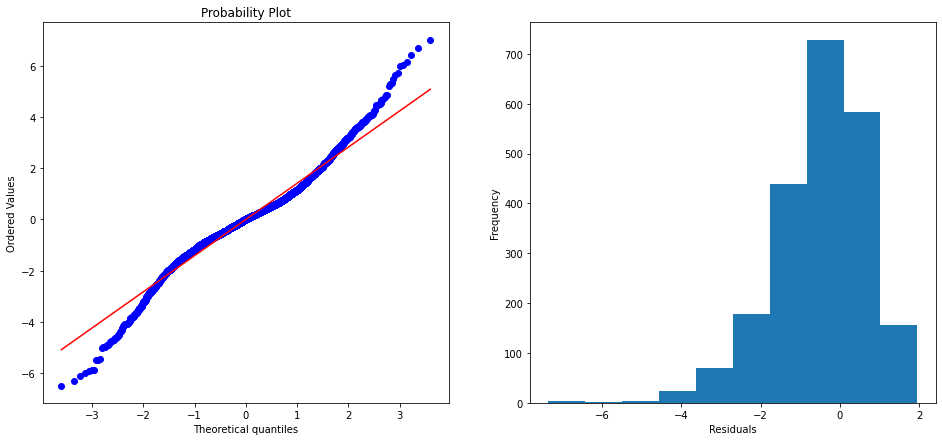

In [21]:
m4 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc + urban \
             + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans',
             data=botswana)

fitted_4 = m4.fit(cov_type='HC1')
print(fitted_4.summary())

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sc.stats.probplot(fitted_4.resid, dist='norm', plot=plt)
plt.subplot(1,2,2)
np.log(fitted_4.resid).plot.hist()
plt.xlabel('Residuals')
plt.show()

Посмотрим, не стала ли модель от удаления трёх признаков значимо хуже, с помощью критерия Фишера:

In [22]:
print("F=%f, p=%f, k1=%f" % m2.fit().compare_f_test(m4.fit()))

F=0.919236, p=0.467231, k1=5.000000


#### 9. Признак $usemeth\_noans$ значим по критерию Стьюдента, то есть, при его удалении модель значимо ухудшится. Но вообще-то отдельно его удалять нельзя: из-за того, что мы перекодировали пропуски в usemeth произвольно выбранным значением $c_{usemeth}=-1$, удалять $usemeth\_noans$ и $usemeth$ можно только вместе.

Удалите из текущей модели $usemeth\_noans$ и $usemeth$. Проверьте критерием Фишера гипотезу о том, что качество модели не ухудшилось. Введите номер первой значащей цифры в достигаемом уровне значимости (например, если вы получили $5.5\times10^{-8}$, нужно ввести 8).

Если достигаемый уровень значимости получился маленький, верните удалённые признаки; если он достаточно велик, оставьте модель без $usemeth$ и $usemeth\_noans$. 

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     611.3
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:05:00   Log-Likelihood:                -7825.7
No. Observations:                4348   AIC:                         1.568e+04
Df Residuals:                    4335   BIC:                         1.576e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1931      0.202     -5.

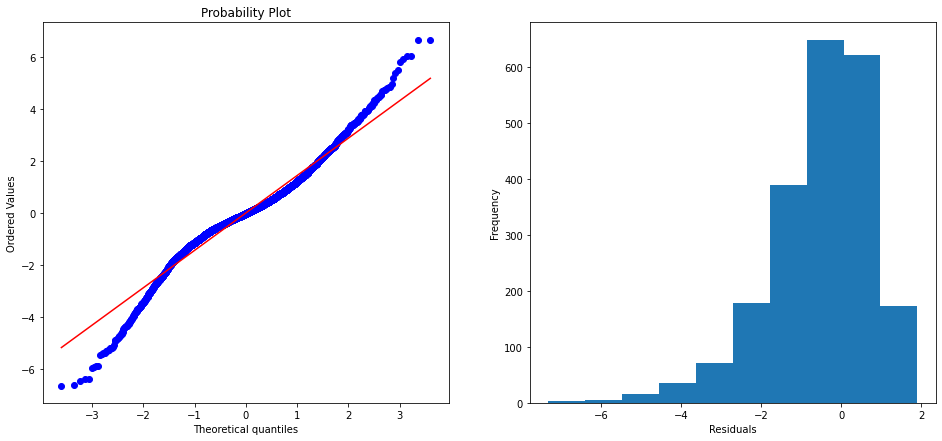

In [23]:
m5 = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + agefm + heduc + urban \
             + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans',
             data=botswana)

fitted_5 = m5.fit()
print(fitted_5.summary())

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
sc.stats.probplot(fitted_5.resid, dist='norm', plot=plt)
plt.subplot(1,2,2)
np.log(fitted_5.resid).plot.hist()
plt.xlabel('Residuals')
plt.show()

Посмотрим, не стала ли модель от удаления двух признаков значимо хуже, с помощью критерия Фишера:

In [24]:
print("F=%f, p=%f, k1=%f" % m4.fit().compare_f_test(m5.fit()))

F=92.890582, p=0.000000, k1=2.000000


Критерий Фишера говорит нам, что качество модели сильно ухудшилось после удаления 2 признаков. Достигаемый уровень значимости p получился маленький ~ 0, поэтомц возвращаем удалённые признаки и пользуемся моделью #4 - $m_4$

#### 10. Посмотрите на доверительные интервалы для коэффициентов итоговой модели (не забудьте использовать поправку Уайта, если есть гетероскедастичность ошибки) и сделайте правильные выводы.

### Выводы

Итоговая модель объясняет 64% вариации отклика - объясняемой переменной $ceb$. 

In [25]:
model = smf.ols('ceb ~ age + educ + idlnchld + knowmeth + usemeth + agefm + heduc + urban \
             + electric + bicycle + nevermarr + idlnchld_noans + heduc_noans + usemeth_noans',
             data=botswana)

fitted_val = model.fit(cov_type='HC1')
print(fitted_val.summary())

                            OLS Regression Results                            
Dep. Variable:                    ceb   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     463.4
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:05:01   Log-Likelihood:                -7734.5
No. Observations:                4348   AIC:                         1.550e+04
Df Residuals:                    4333   BIC:                         1.559e+04
Df Model:                          14                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0698      0.258     -4.